<a href="https://colab.research.google.com/github/nalsadi/ME736_Dev/blob/main/RNN_for_Movement_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME 736/777 - Reccurent Neural Networks 

## What is a recurrent neural network and why are they useful?

A recurrent neural network (RNN) is a type of artificial neural network where connections between nodes form a directed graph along a temporal sequence. This allows it to exhibit dynamic temporal behavior for a time series or sequence prediction problems. Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs. This makes them applicable to tasks such as unsegmented, connected handwriting recognition or speech recognition.

#### **Key Advantages of Utilizing an RNN:**

1.   Processes sequential data
2.   Can memorize and store previous results
3. Takes into account both the current and the previous results in the computation of new results
4. Regardless of the increasing size of the input, the model size remains fixed


## What are the different types of recurrent neural network? 

The four commonly used types of Recurrent Neural Networks are:

1. **One-to-One:**
The simplest type of RNN is One-to-One, which allows a single input and a single output. It has fixed input and output sizes and acts as a traditional neural network. The One-to-One application can be found in Image Classification.

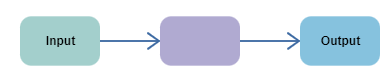



2. **One-to-Many**
One-to-Many is a type of RNN that gives multiple outputs when given a single input. It takes a fixed input size and gives a sequence of data outputs. Its applications can be found in Music Generation and Image Captioning.

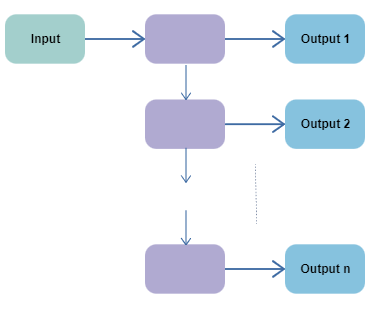

3. **Many-to-One**
Many-to-One is used when a single output is required from multiple input units or a ﻿sequence of them. It takes a sequence of inputs to display a fixed output. Sentiment Analysis is a common example of this type of Recurrent Neural Network.

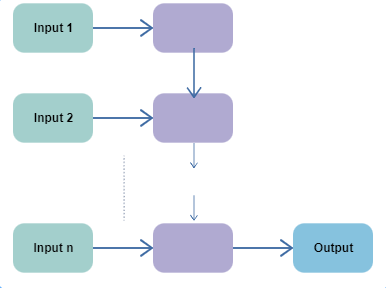


4. **Many-to-Many**
Many-to-Many is used to generate a sequence of output data from a sequence of input units.

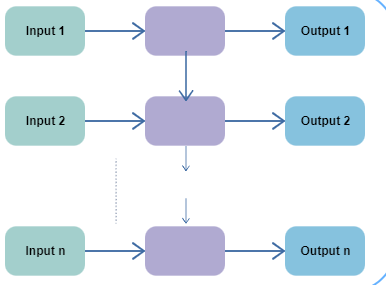


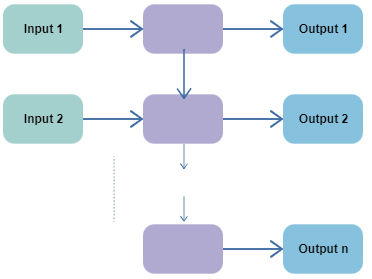

## What are some problems with recurrent neural networks? 

The computation time is slow as it is recurrent.

**Exploding Gradient:** An exponential increase in model weights occur due to an accumulation of large gradient errors.

**Vanishing Gradient:** The gradients become too small and unable to make significant changes in the model weights.

# Library Imports

First we will import all the necessary libraries and modules

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, SimpleRNN
from tensorflow.keras.utils import to_categorical, plot_model
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import imageio
from IPython.display import Image as imageshow

# Import Data

We will be using a modified version of the [LASIESTA](https://www.gti.ssr.upm.es/data/lasiesta_database.html) dataset provided by the Image Processing Group at the Polytechnic University of Madrid. The modified data can be found within this git repo: https://github.com/nalsadi/ME736-777.git

In [ ]:
!git clone https://github.com/nalsadi/ME736-777.git

Cloning into 'ME736-777'...
remote: Enumerating objects: 523, done.
remote: Counting objects: 100% (523/523), done.
remote: Compressing objects: 100% (494/494), done.
remote: Total 523 (delta 27), reused 519 (delta 27), pack-reused 0
Receiving objects: 100% (523/523), 588.13 KiB | 16.80 MiB/s, done.
Resolving deltas: 100% (27/27), done.


# Data Processing 

Each folder contains a set of sequential images depicting a person walking in a specific direction, either right or left. We will create an training set which contains all of our data in the format: (Person,Frame,Width,Height,Channels)

In [ ]:
p1l = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p1_left/*.png"))])[:60]
p2l = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p2_left/*.png"))])[:60]
p3l = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p3_left/*.png"))])[:60]
p1r = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p1_right/*.png"))])[:60]
p2r = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p2_right/*.png"))])[:60]
p3r = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/p2_right/*.png"))])[:60]##### Chnage to right

With 6 people with 60 frames per sequence at a frame dimension of 256x256 in RBG(3 Channels), we should expect a dimensionality of **(6,60,256,256,3)**.

In [ ]:
x =  np.stack([p1l,p2l,p3l,p1r,p2r,p3r],axis=0)

We will quickly define a set labels for the training data. The first three are left (0) and the last three are right (0). 

In [ ]:
y_train = to_categorical([0,0,0,1,1,1])

# Visualize Data

We can see how the sequences actually look when we play them as a GIF. 

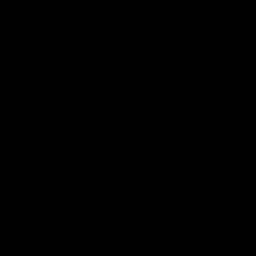

In [ ]:
imageio.mimsave('movie.gif', p1l[0:,:,:]) # Should be walking left
imageshow(open('movie.gif','rb').read())

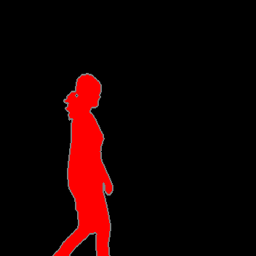

In [ ]:
imageio.mimsave('movie.gif', p1r[0:,:,:]) # Should be walking right
imageshow(open('movie.gif','rb').read())

## Model Architecture

To reduce model complexity and prevent a large monolith architecture, we will use a two phase architecture:

   1. Feature Extractor: 
        *   This model will go through each frame and extract only the necessary features from each frame. This will reduce the data dimensionality from (6,60,256,256,3) to (6,60,2048). We will use a pre-trained model to do this so that we don't have to train a convolutional neural network from scratch.


   2. Sequence Predictor:
        * This model will go through each person's walking sequence and determine what direction they are walking. The task will categorical (None, Left, Right).


## Feature Extraction

For every frame use Inception to extract the features

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(256, 256, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((256, 256, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    model = keras.Model(inputs, outputs, name="feature_extractor")
    

    return model

In [ ]:
feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
ft_array = np.zeros(shape=(6, 60, 2048), dtype="float32")
for sample_index, sample in enumerate(x):   
    for frame_index , frame in enumerate(sample):
        fts = feature_extractor.predict(frame[tf.newaxis,:,:])
        ft_array[sample_index,frame_index] = fts

# Set Up Sequence Model

In [ ]:
input_shape = ft_array.shape[1],ft_array.shape[2]
batch_size = 128
units = 256
dropout = 0.2

In [ ]:
model = Sequential()
model.add(SimpleRNN(units=units,
                    dropout=dropout,
                    input_shape=input_shape))
model.add(Dense(2))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 256)               590080    
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
 activation_97 (Activation)  (None, 2)                 0         
                                                                 
Total params: 590,594
Trainable params: 590,594
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.fit(ft_array, y_train, epochs=20, batch_size=batch_size)

Epoch 1/20
1/1 [==============================] - 1s 996ms/step - loss: 0.9242 - accuracy: 0.5000
Epoch 2/20
1/1 [==============================] - 0s 84ms/step - loss: 0.7515 - accuracy: 0.5000
Epoch 3/20
1/1 [==============================] - 0s 85ms/step - loss: 0.8194 - accuracy: 0.5000
Epoch 4/20
1/1 [==============================] - 0s 77ms/step - loss: 0.5163 - accuracy: 0.8333
Epoch 5/20
1/1 [==============================] - 0s 83ms/step - loss: 0.2795 - accuracy: 1.0000
Epoch 6/20
1/1 [==============================] - 0s 79ms/step - loss: 0.2557 - accuracy: 0.8333
Epoch 7/20
1/1 [==============================] - 0s 85ms/step - loss: 0.2043 - accuracy: 0.8333
Epoch 8/20
1/1 [==============================] - 0s 86ms/step - loss: 0.1985 - accuracy: 1.0000
Epoch 9/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0945 - accuracy: 1.0000
Epoch 10/20
1/1 [==============================] - 0s 88ms/step - loss: 0.0887 - accuracy: 1.0000
Epoch 11/20
1/1 [===========

# Testing Model 

In [ ]:
test_left = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/test_left/*.png"))])[:60]
test_right = np.array([np.array(Image.open(fname).resize((256,256))) for fname in sorted(glob.glob("ME736-777/data/lasiesta/test_right/*.png"))])[:60]

In [ ]:
test =  np.stack([test_left, test_right],axis=0)

In [ ]:
test_ft_array = np.zeros(shape=(2, 60, 2048), dtype="float32")
for sample_index, sample in enumerate(test):   
    for frame_index , frame in enumerate(sample):
        fts = feature_extractor.predict(frame[tf.newaxis,:,:])
        test_ft_array[sample_index,frame_index] = fts

In [ ]:
y_test = to_categorical([0,1])

In [ ]:
_, acc = model.evaluate(test_ft_array,y_test)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

NameError: ignored